In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cProfile
from collections import deque, Counter
from time import time

from calculo.video import centroid  # Cython


def center_of_square(contour):
    return centroid(*cv2.boundingRect(contour))


def image_proccess(frame):
    kernel = np.ones((3,3),np.uint8)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    dilation = cv2.dilate(gray, kernel, iterations=1)
    binary = cv2.threshold(gray, 240., 255., cv2.THRESH_BINARY)[1]
    contours= cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    mark = np.array(map(center_of_square, contours))
    return mark.shape[0], mark


def roi_center(array, amp=1.15):
    y1 = array[0][1]
    y2 = array[-1][1]
    dy = (y1 - y2)*amp
    center = (y1 + y2) / 2
    return(center - dy, center +  dy)  # límite superior, límite inferior


def grouping(markers, n_expected, kroi=False):
    if kroi:
        Y = markers[:, 1]
        G0 = markers[Y < kroi[0]]
        G1 = markers[np.logical_and(Y > kroi[0], Y < kroi[1])]
        G2 = markers[Y > kroi[1]]
    else:
        G0 = markers[5:, :]
        G1 = markers[3:5, :]
        G2 = markers[:3, :]
    n_obtained = (G0.shape[0], G1.shape[0], G2.shape[0])
    boolean_interpolate = [a != b for a, b in zip(n_expected, n_obtained)]
    return(boolean_interpolate, (G0, G1, G2))


def diff(array, dt=1):
    vel = []
    for prev, new in zip(array[:-1], array[1:]):
        if prev and new:
            vel.append((new - prev) / dt)
        else:
            vel.append(None)
    vel.append(dt)  # este ultimo es arbitrario, pero no puede ser 0 o None
    return vel


def get_direction(foot_group):
    x_antepie = foot_group[0, 0]
    x_talon = foot_group[1, 0]
    if x_talon < x_antepie:
        return 1
    else:
        return -1


def sort_foot_markers(foot, direction=False):
    if foot.shape[0] != 3 and direction:
        return None
    x1, x2, refer = foot[:, 0]
    if direction:
        if direction > 0:
            if x1 < x2:
                talon = foot[0]
                antepie = foot[1]
            else:
                talon = foot[1]
                antepie = foot[0]
        elif direction < 0:
            if x1 < x2:
                talon = foot[1]
                antepie = foot[0]
            else:
                talon = foot[0]
                antepie = foot[1]
    else:
        values = ((abs(refer - x1), 0),
                  (abs(refer - x2), 1))
        talon = foot[min(values)[1]]
        antepie = foot[max(values)[1]]            
    maleolo = foot[-1]
    return np.array((antepie, talon, maleolo))


def set_direction(foot_markers, M=3):
    Y = map(lambda m: m[0][1] if  (isinstance(m, np.ndarray) and m.shape[0] != 0) else np.random.randint(0, 1000), foot_markers)
    vel = diff(Y)
    direction = 0
    for v , arr in zip(vel, foot_markers):
        if v == 0 and arr.shape[0] == M:
            sorted_foot = sort_foot_markers(arr)
            direction += get_direction(sorted_foot)
    return 1 if direction > 0 else -1


def linear(x, x1, x2, y1, y2):
    num = (x - x1)*(y2 - y1)
    div = (x2 - x1)
    if not div.all():
        return (y2 + y1) / 2
    return num / div + y1


def interpolate(A, B, n_steps):
    n_steps += 1
    x1, y1 = A.T
    x2, y2 = B.T
    dx = np.round((x2 - x1) / float(n_steps))
    interpolated = []
    for n in xrange(1, n_steps):
        X = x1 + dx*n
        Y = linear(X, x1, x2, y1, y2)
        interpolated.append(np.array((X, Y), dtype=int).T)
    return interpolated


def interval(bolean, index):
    Xi = 0
    for b, i in zip(bolean, index):
        if b:
            if not Xi:
                Xi = i-1
            if i == index[-1]:
                yield(Xi, i + 1)
        else:
            if Xi:
                yield(Xi, j + 1)
                Xi = 0
        j = i


def homogenize(binary, iterations=5):
    kernel = 1
    for __ in xrange(iterations):
        for i, value in enumerate(binary):
            binary[i] += kernel + 1
            kernel = value
        for i, value in enumerate(binary):
            if value == 1:
                binary[i] = 0
    for i, value in enumerate(binary):
        if value == 0:
            for j in xrange(1, iterations + 1):
                binary[i - j] = 0
        else:
            binary[i] = 1

#def fix_in(tyt):
#    for group in (0, 1, 2):
#        count = 0
#        for ai, bi in interval(tyt._to_interpolate[group], tyt._to_interpolate['index_order']):
#            ai -= tyt.start_frame
#            bi -= tyt.start_frame
#            dt = (bi - ai) - 1
#            count += dt
#            A = tyt._frames[group][ai]
#            B = tyt._frames[group][bi]
#            for j, arr in zip(xrange(ai + 1, bi), interpolate(A, B, dt)):
#                tyt._frames[group][j] = arr

In [2]:
class Trayectoria(object):
    u"""."""

    
    def __init__(self):
        u"""."""
        self._start = None
        self._end = None
        self._fps = None
        self._frames = {0:[], 1:[], 2:[], 'index_order': []}
        self._to_interpolate = {0:[], 1:[], 2:[], 'index_order': []}
        self._stats = {'interpolated': [], 'cycle': []}

    @property
    def start_frame(self):
        return self._start

    @start_frame.setter
    def start_frame(self, index):
        if self._start is None:
            self._start = index

    @property
    def end_frame(self):
        return self._end

    @end_frame.setter
    def end_frame(self, index):
        if self._end is None:
            self._end = index
            self.num_frames = (index - self._start) + 1

    def add_frame(self, index, groups):
        u"""."""
        for i, g in zip((0, 1, 2), groups):
            self._frames[i].append(g)
        self._frames['index_order'].append(index)

    def add_to_interpolate(self, index, groups):
        u"""."""
        for i, g in zip((0, 1, 2), groups):
            self._to_interpolate[i].append(g)
        self._to_interpolate['index_order'].append(index)

    def rm_lastNframes(self, n):
        u"""."""
        for __ in xrange(n):
            self._frames[0].pop()
            self._frames[1].pop()
            self._frames[2].pop()
            self._frames['index_order'].pop()
            self._to_interpolate[0].pop()
            self._to_interpolate[1].pop()
            self._to_interpolate[2].pop()
            self._to_interpolate['index_order'].pop()

    def fix_in(self):
        self._direction = set_direction(self._frames[2])
        self._frames[2] = [sort_foot_markers(X, self._direction) for X in self._frames[2]]
        for group in (0, 1, 2):
            count = 0
            for ai, bi in interval(self._to_interpolate[group], self._to_interpolate['index_order']):
                ai -= self.start_frame
                bi -= self.start_frame
                dt = (bi - ai) - 1
                count += dt
                A = self._frames[group][ai]
                B = self._frames[group][bi]
                for j, arr in zip(xrange(ai + 1, bi), interpolate(A, B, dt)):
                    self._frames[group][j] = arr
            self._stats['interpolated'].append((group, count / float(self.num_frames)))    

    def cycle_definition(self, fps, level=0.15):
        u"""."""
        # primer proceso. Se detecta la situacion de apoyo y balanceo
        velocities = []
        self._velocities = []
        for i in (0, 1):
            vel = diff([X[i][1] for X in self._frames[2]], 1/fps)
            velocities.append(vel)
            self._velocities.append(vel)
        limit = max(velocities[0] + velocities[1]) * level
        for i in (0, 1):
            velocities[i] = [abs(x) > limit for x in velocities[i]]
            homogenize(velocities[i])
        self._phases = [not (x + y) < 2 for x, y in zip(velocities[0], velocities[i])]

        # segundo proceso. Se detectan ciclos dentro del trayecto.
        cycle = []
        self._cycles = []
        for i, (prev, nextt) in enumerate(zip(self._phases[:-1], self._phases[1:])):
            if prev and not nextt:  # (BALANCEO-APOYO)
                cycle.append(i+1)
            if nextt and not prev: # (APOYO-BALANCEO)
                toeoff = i+1
            if len(cycle) == 2:
                self._cycles.append(((cycle[0], toeoff-1), (toeoff, cycle[1]-1)))
                cycle = [cycle[-1]]

In [3]:
# %%time
# En este bloque se abre el video y se procesan las imágenes en busqueda de los
# marcadores.
# Solo se agregan al arreglo de datos(list) los arreglos de marcadores que se 
# delimitan en un intervalo cerrado cuyos extremos(arreglo de marcadores tambien)
# poseen 7 marcadores.

# path = '/home/mariano/Descargas/VID_20170720_132629833.mp4'  # Belen
# path = '/home/mariano/Descargas/VID_20170720_133000367.mp4'  # Belen corriendo
path = '/home/mariano/Descargas/VID_20170728_112226772.mp4'  # Maxi Hissa
# path = '/home/mariano/Descargas/VID_20170810_101859517.mp4'  # Ferrando (sm)

vid = cv2.VideoCapture(path)
fps = vid.get(cv2.CAP_PROP_FPS)
is_frame, frame = vid.read()
expected_markers = (2, 2, 3)
M = sum(expected_markers)
safe_None = 2 * fps
last_M = 0
active = False
count_non_data = 0
trayectories = []
i = 0

t = Trayectoria()
while is_frame:
    m, mark = image_proccess(frame)
    if mark.any():
        if m == M:
            active = True
            t.start_frame = i
            last_M = i
            count_non_data = 0
        if active:
            if m != M:
                to_interp, groups = grouping(mark, expected_markers, kr)
                t.add_frame(i, groups)
                t.add_to_interpolate(i, to_interp)
            else:
                __, groups = grouping(mark, expected_markers)
                kr = roi_center(groups[1])
                t.add_frame(i, groups)
    else:
        count_non_data += 1
        if active and count_non_data < safe_None:
            G0 = np.random.randint(0, 100, (2, 2))
            G1 = np.random.randint(0, 100, (2, 2))
            G2 = np.random.randint(0, 100, (3, 2))
            t.add_frame(i, (G0, G1, G0))
            t.add_to_interpolate(i, (True, True, True))
        else:
            if active:
                backwards = (i - 1) - last_M
                t.rm_lastNframes(backwards)
                t.end_frame = i - backwards - 1
                trayectories.append(t)
                t = Trayectoria()
                active = False
    is_frame, frame = vid.read()
    i += 1

((4, 21), (22, 34))


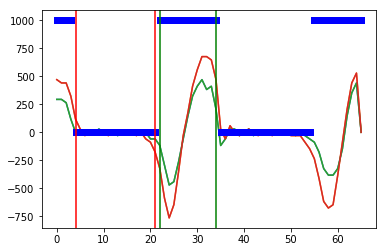

((2, 23), (24, 37))
((38, 65), (66, 80))


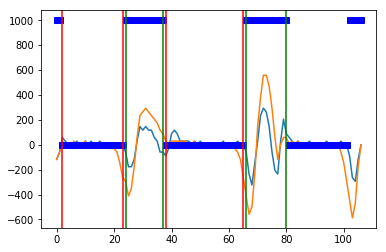

((21, 44), (45, 57))


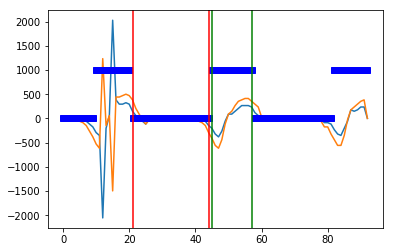

((13, 31), (32, 45))


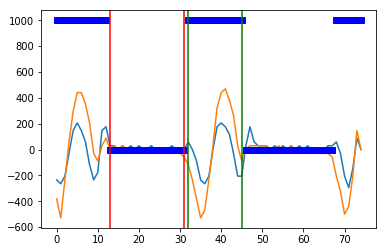

((4, 21), (22, 38))


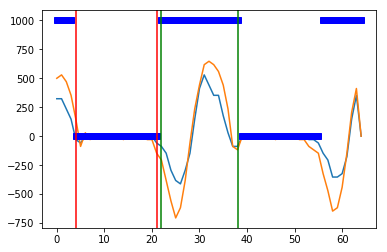

((21, 39), (40, 54))


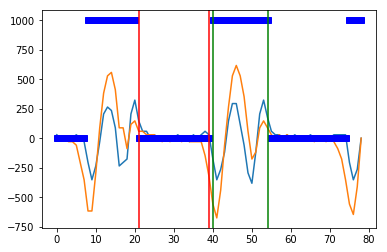

((35, 52), (53, 67))


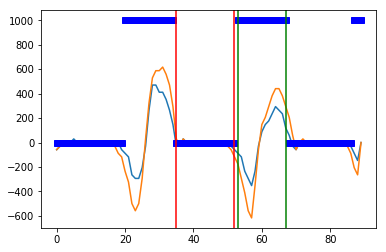

((4, 27), (28, 40))
((41, 62), (63, 75))


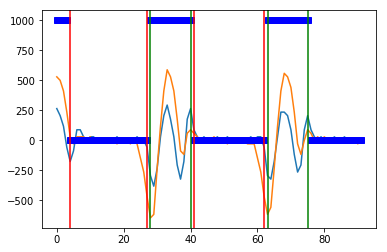

((24, 46), (47, 58))


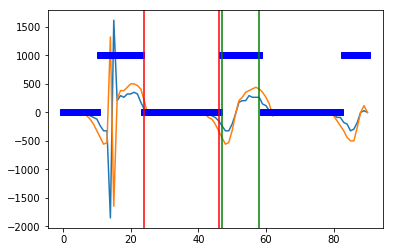

((33, 54), (55, 68))


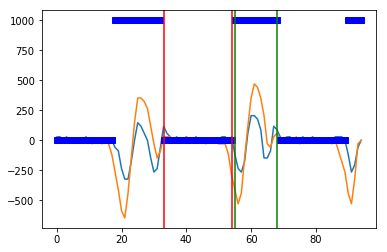

((23, 44), (45, 55))


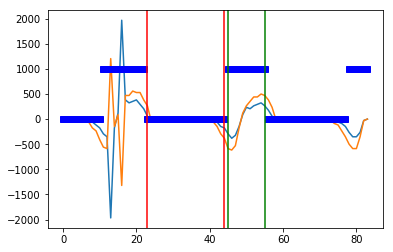

((24, 46), (47, 61))


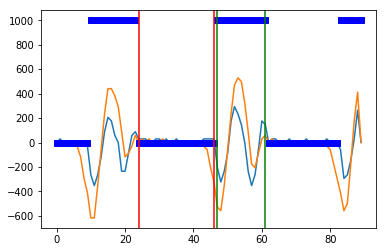

((28, 45), (46, 61))


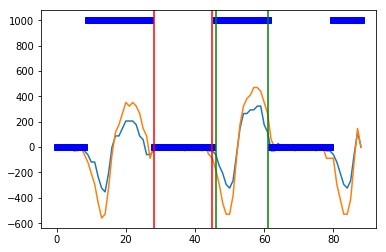

In [14]:
for t in trayectories:
    t.fix_in()
    t.cycle_definition(fps, 0.1)
    plt.plot(t._velocities[0])
    plt.plot(t._velocities[1])
    plt.plot([x*1000 for x in t._phases], 'bs')
    for ciclo in t._cycles:
        apo, bal = ciclo
        plt.axvline(apo[0], -1000, 1000, color='r')
        plt.axvline(apo[1], -1000, 1000, color='r')
        plt.axvline(bal[0], -1000, 1000, color='g')
        plt.axvline(bal[1], -1000, 1000, color='g')
        print ciclo
    plt.show()

In [7]:
# def Angle(A, B):
#     """Calcula el ángulo(theta) entre dos arreglos de vectores(fila) según la
#         definición de producto escalar:
#             u·v = |u||v|cos(theta)
#     Args:
#         A: arreglo ``np.array`` de vectores fila con las posiciones x, y
#             respectivamente de un punto en el plano.
#         B: lo mismo que A
#     Returns:
#         arreglo ``np.array`` de ángulos en grados.
#     """
#     if A is None:
#         return None
#     normA = np.linalg.norm(A)
#     normB = np.linalg.norm(B)
#     pInternoAB = A.dot(B.T).diagonal()
#     radiansAngle = np.arccos(pInternoAB / (normA * normB))
#     return np.degrees(radiansAngle)


In [8]:
# tight = map(lambda x, y: x - y if x is not None else None, pi_tight , ps_tight)
# hipAngle = [Angle(x, np.matrix((1, 0))) for x in tight]
# hipAngle = map(lambda x: 90 - x if x is not None else None, hipAngle)

In [9]:
# leg = map(lambda x, y: x - y if x is not None else None, pi_leg , ps_leg)
# lowKneeAngle = [Angle(x, np.matrix((1, 0))) for x in leg]
# lowKneeAngle = map(lambda x: x - 90 if x is not None else None, lowKneeAngle)
# KneeAngle = map(lambda x, y: x + y if x is not None else None, lowKneeAngle, hipAngle)

In [10]:
# foot = map(lambda x, y: x - y if x is not None else None, pa_foot , pp_foot)
# AnkleAngle = [Angle(x, np.asmatrix(y)) for x, y in zip(leg, foot)]
# AnkleAngle = map(lambda x: 90 - x if x is not None else None, AnkleAngle)

In [11]:
# from time import sleep
# array = ps_tight

# vid = cv2.VideoCapture(path)
# n = 0
# while True:
#     is_frame, frame = vid.read()
#     if is_frame is False:
#         break
#     marker = array[n]
# #    if marker is not None:
# #        for arr in marker:
# #            cv2.circle(frame, (arr[0], arr[1]), 7, (0, 0, 255), -1)
#     if marker is not None:
#         cv2.circle(frame, (marker[0], marker[1]), 7, (0, 0, 255), -1)
#     cv2.imshow(path, cv2.resize(frame, None, fx=.4, fy=.4))
#     k = cv2.waitKey(30) & 0xff
#     if k == 27:
#         break
#     n += 1
#     sleep(.1)
# vid.release()
# cv2.destroyAllWindows()
